### <font color='darkblue'>Multi-Class Classification of Hand-Sign Images with TensorFlow</font>

In [ ]:
import numpy as np
import math
import h5py

import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1)

# Note: Uses TensorFlow version: 1.8.0

### 1. Data 

- **Training set**: 1080 pictures (64 x 64 pixels) of signs representing numbers from 0 to 5 (180 pictures per number).
- **Test set**: 120 pictures (64 x 64 pixels) of signs representing numbers from 0 to 5 (20 pictures per number).

&ensp;&ensp;&ensp;<span style='font-size:0.92em'><u>Figure 1</u>: Examples of original (high-resolution) images and corresponding one-hot encodings. \[Credit: A. Ng, et al.\]</span>
<img src="images/hands.png" style="width:800px;height:350px;">
<img src="images/onehot.png" style="width:600px;height:150px;">

In [2]:
# Load dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 3


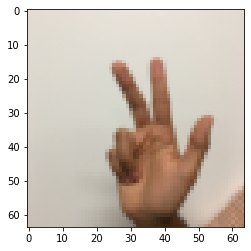

In [3]:
# Test (low-resolution) image (64 x 64 pixels)
index = 68
plt.imshow(X_train_orig[index])
print ('y = ' + str(np.squeeze(Y_train_orig[:, index])))

In [4]:
# Flatten the data
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T

# Normalize the data
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.

# Convert labels to one-hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)

print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (12288, 1080)
Y_train shape: (6, 1080)
X_test shape: (12288, 120)
Y_test shape: (6, 120)


### 2. Model

The model is a **six-class classifier** consisting of a three-layer (25 - 12 - 6) network with the following activations:

**LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX**

### 3. Implementation

In [5]:
# FUNCTION: create_placeholders

def create_placeholders(n_x, n_y):
    '''
    Create placeholders for TensorFlow session

    Arguments:
    n_x -- scalar, size of image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (0 - 5; i.e., 6)

    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "tf.float32"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "tf.float32"
    '''

    X = tf.placeholder(tf.float32, shape = [n_x, None], name = 'X')
    Y = tf.placeholder(tf.float32, shape = [n_y, None], name = 'Y')

    return X, Y

In [6]:
X, Y = create_placeholders(12288, 6)
print ('X = ' + str(X))
print ('Y = ' + str(Y))

X = Tensor("X:0", shape=(12288, ?), dtype=float32)
Y = Tensor("Y:0", shape=(6, ?), dtype=float32)


In [8]:
# FUNCTION: initialize_parameters

def initialize_parameters():
    '''
    Initialize parameters with shapes:
                        W1 : [25, 12288]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]

    Returns:
    parameters -- dictionary of tensors containing W1, b1, W2, b2, W3, b3
    '''

    tf.set_random_seed(1)

    W1 = tf.get_variable("W1", [25,12288], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [25,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12,25], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [12,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [6,12], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [6,1], initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}

    return parameters

In [9]:
tf.reset_default_graph()
with tf.Session() as sess:
    parameters = initialize_parameters()
    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))
    print("W2 = " + str(parameters["W2"]))
    print("b2 = " + str(parameters["b2"]))

W1 = <tf.Variable 'W1:0' shape=(25, 12288) dtype=float32_ref>
b1 = <tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref>
W2 = <tf.Variable 'W2:0' shape=(12, 25) dtype=float32_ref>
b2 = <tf.Variable 'b2:0' shape=(12, 1) dtype=float32_ref>


In [11]:
# FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    '''
    Implements forward prop for the model

    Arguments:
    X -- input placeholder, of shape (input size, number of examples)
    parameters -- Python dictionary with parameters "W1", "b1", "W2", "b2", "W3", "b3",
                  with shapes specified in initialize_parameters

    Returns:
    Z3 -- output of last linear unit

    Note: TF gives the last linear-layer output to the function that computes the loss; 
          i.e., a3 isn't needed.
    '''

    # Retrieve the parameters from dictionary 'parameters' 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    Z1 = tf.add(tf.matmul(W1,X),b1)                        
    A1 = tf.nn.relu(Z1)                                    
    Z2 = tf.add(tf.matmul(W2,A1),b2)                       
    A2 = tf.nn.relu(Z2)                                    
    Z3 = tf.add(tf.matmul(W3,A2),b3)                       

    return Z3

In [12]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(12288, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    print('Z3 = ' + str(Z3))

Z3 = Tensor("Add_2:0", shape=(6, ?), dtype=float32)


In [13]:
# FUNCTION: compute_cost 

def compute_cost(Z3, Y):
    '''
    Computes the cost

    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3

    Returns:
    cost - Tensor of the cost function
    '''

    # To fit the TF requirement for tf.nn.softmax_cross_entropy_with_logits(..., ...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))

    return cost

In [ ]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(12288, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    print("cost = " + str(cost))

<span style='font-size:0.9em'>cost&emsp;Tensor("Mean:0", shape=(), dtype=float32)</span>

In [30]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    '''
    Implements the three-layer TensorFlow network:  LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX

    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs

    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    '''

    ops.reset_default_graph()                         # To be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)
    seed = 3
    (n_x, m) = X_train.shape                          # n_x: input size, m: number of examples in the training set
    n_y = Y_train.shape[0]                            # n_y: output size
    costs = []                                        # To keep track of the cost

    # Create placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)
    
    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation
    Z3 = forward_propagation(X, parameters)
    
    # Cost function
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer (Adam)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()
    
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # The line that runs the graph on a minibatch:
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _, minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                epoch_cost += minibatch_cost / minibatch_size

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ('Cost after epoch %i: %f' % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per fives)')
        plt.title('Learning rate =' + str(learning_rate))
        plt.show()

        # Save parameters to variable
        parameters = sess.run(parameters)
        print ('Parameter training complete\n')

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float')

        print ('Train Accuracy:', accuracy.eval({X: X_train, Y: Y_train}))
        print ('Test Accuracy:', accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Cost after epoch 0: 1.913693
Cost after epoch 100: 1.048173
Cost after epoch 200: 0.756171
Cost after epoch 300: 0.590862
Cost after epoch 400: 0.483527
Cost after epoch 500: 0.392992
Cost after epoch 600: 0.323783
Cost after epoch 700: 0.262361
Cost after epoch 800: 0.210326
Cost after epoch 900: 0.171868
Cost after epoch 1000: 0.146932
Cost after epoch 1100: 0.111116
Cost after epoch 1200: 0.088654
Cost after epoch 1300: 0.062818
Cost after epoch 1400: 0.052603


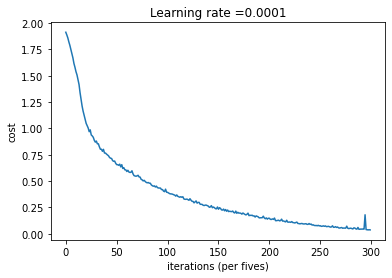

Parameter training complete

Train Accuracy: 0.9990741
Test Accuracy: 0.725


In [31]:
parameters = model(X_train, Y_train, X_test, Y_test)